In [1]:
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfTransformer

In [5]:
with open('train.json') as data_file:    
    data = json.load(data_file) # create a list of data

In [6]:
data[0]

{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [7]:
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    for i in range(len(json)):
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'southUS'
        ingredientsPerCuisine = json[i]['ingredients']
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)   # add this new cuisine into cuisine list
            dictCuisineIngred[cuisine] = ingredientsPerCuisine   #create a new dic pair
            
        else: 
            currentList = dictCuisineIngred[cuisine]   #get ingredient value out
            currentList.extend(ingredientsPerCuisine)   # append ingredients in
            dictCuisineIngred[cuisine] = currentList    #put ingredients value back
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients

In [8]:
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #return the index of the ingredient as per its position in ingredients list
            termCountMatrix[i,j] += 1   #1 means the ingredient appears one time, cuisine is row and column is ingredient

        i += 1   #next cuisine

    return termCountMatrix

In [9]:
dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)


array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  2., 67.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [27.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [10]:
import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')

In [11]:
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

In [13]:
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)  # creating the tf-idf matrix

In [14]:
pca = PCA(n_components=2)  # running PCA to reduce to 2 dimensions
# print(pca.explained_variance_ratio_)   
reduced_data = pca.fit_transform(tfIdf_Matrix)


In [17]:
pca2dataFrame = pd.DataFrame(reduced_data)   # converting to pandas dataframe for convenience:
pca2dataFrame.columns = ['PC1', 'PC2']
pca2dataFrame.shape

(20, 2)

In [11]:
from sklearn.cluster import KMeans

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(3)

In [12]:
i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1

C:\Users\B0175\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


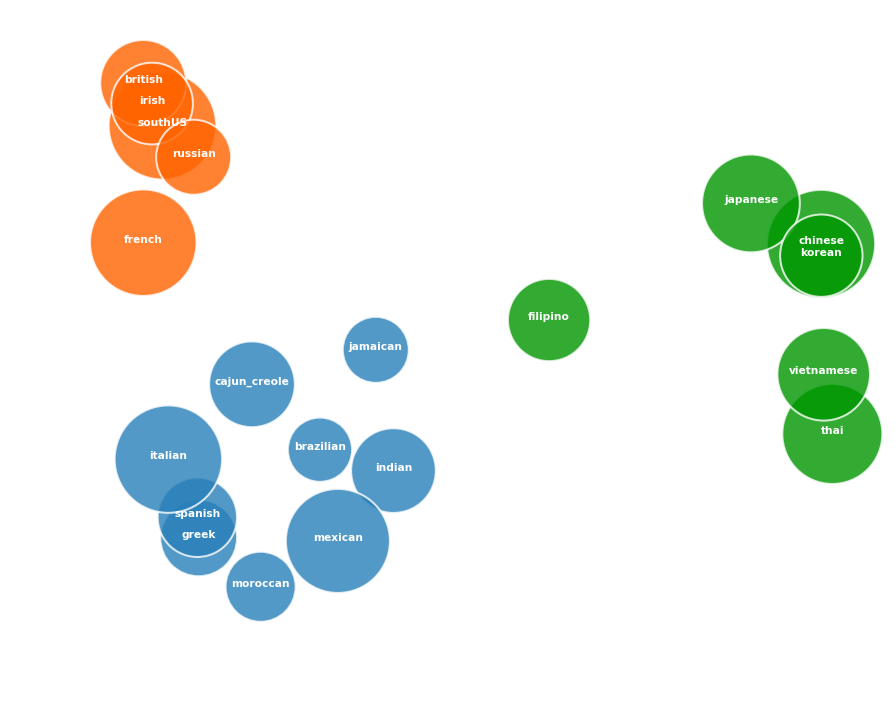

In [13]:
from pylab import *
from scipy import *
import matplotlib.pyplot as plt

rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show()